# Data set 5<br>
This dataset included responses from a gas multisensor device deployed in an Italian city from 2004 to April 2005. Hourly response averages and gas concentration references from a certified analyzer were recorded. For the experiments involving the creation of new records, the data from 2004 was used as the Primary Source, and measurements from 2005 were treated as the new records.<br>
## Preliminaries<br>
Import and load the uses Python packages and modules:

In [1]:
import sys
import os
# Add the parent directory to sys.path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '../main/'))
sys.path.insert(0, parent_directory)
import pandas as pd
import numpy as np
import sim_experiments as smexp_dyn
from datetime import date

Load the data set and prepare it:

In [2]:
df = pd.read_csv("../datasets/ds05_AirQualityUCI.csv", sep=";", decimal=",", na_values=-200)
df.drop(df.columns.values[-2:], axis=1, inplace=True)
# Create a pandas dataframe from the data
df["Date"] = pd.to_datetime(df["Date"],format = '%d/%m/%Y')
df["MonthYear"] = df["Date"].dt.to_period('M')
df["Time"] = pd.to_datetime(df["Time"],format = '%H.%M.%S').dt.time
df.set_index(["Date", "Time"], inplace=True)
dfnum = df.select_dtypes([float, int])
dfnum = dfnum.replace(-200, np.nan).iloc[0:9357,:]
dfnum.drop(columns="NMHC(GT)", inplace=True)

In [3]:
X_PS = dfnum.loc[df["MonthYear"]<"2005-01-01",:]
X_NEW = dfnum.loc[df["MonthYear"]>="2005-01-01",:]

Exploratory analysis showing time series decomposigion as an additive model where each time instant ($x_i$) is the addition of a trend component ($T_i$), a seasonal component ($S_i$) and an error component ($E_i$)

In [4]:
smexp_dyn.plot_time_components_div(pd.concat([X_PS, X_NEW]), X_PS.index, X_NEW.index, 24*7, dsname="ds05comb_weekly", xtxtsize=5, path_figs="../figures/")

'done'

## Primary Source models<br>
Obtain the parameters for the reference batch of data. The function returns a dictionary *ps_dict* with the parameters to compute each one of the drift metrics according to a different ML model and the _indPS_ variable with the indices of the records used for the reference set.

Step [1/6]: Printing the Original Data Set Features =======
Step [1/6]: Starting ...
            CO(GT)  PT08.S1(CO)     C6H6(GT)  PT08.S2(NMHC)      NOx(GT)  \
count  5526.000000  6882.000000  6882.000000    6882.000000  5546.000000   
mean      2.190572  1096.717960    10.631197     960.831590   218.669492   
std       1.484658   220.003823     7.611719     266.526041   207.045968   
min       0.100000   647.000000     0.200000     397.000000     2.000000   
25%       1.100000   932.000000     5.000000     762.000000    82.000000   
50%       1.900000  1060.000000     8.800000     932.000000   149.000000   
75%       2.900000  1229.000000    14.400000    1131.000000   280.000000   
max      11.900000  2040.000000    63.700000    2214.000000  1479.000000   

       PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)            T  \
count   6882.000000  5543.000000   6882.000000  6882.000000  6882.000000   
mean     856.328393   101.693848   1551.836385  1012.879541    20.861479   
st

2023-11-21 18:22:24.204681: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "my_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                130       
                                                                 
 sequential_1 (Sequential)   (None, 12)                132       
                                                                 
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________
Best model - DONE
Data model -  DONE
Permutation test -  DONE
dE-AE summary: 969.4874482154846 s.; 640 b.
Step [3/6]: Finished.


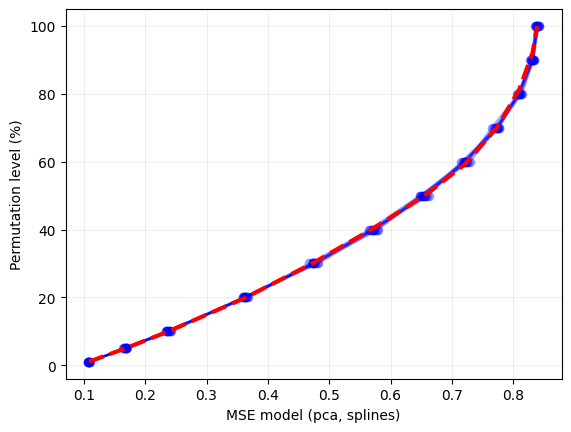

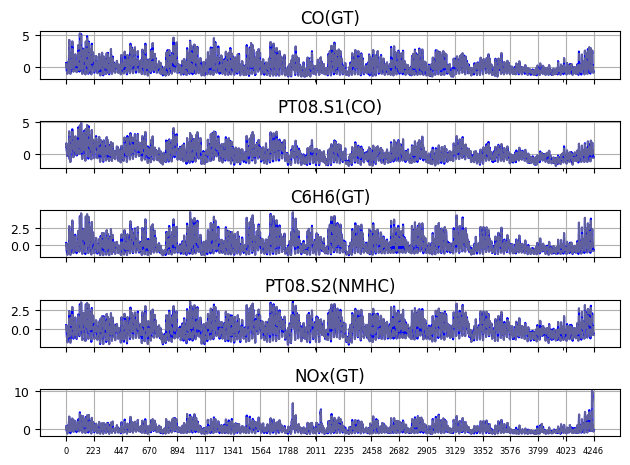

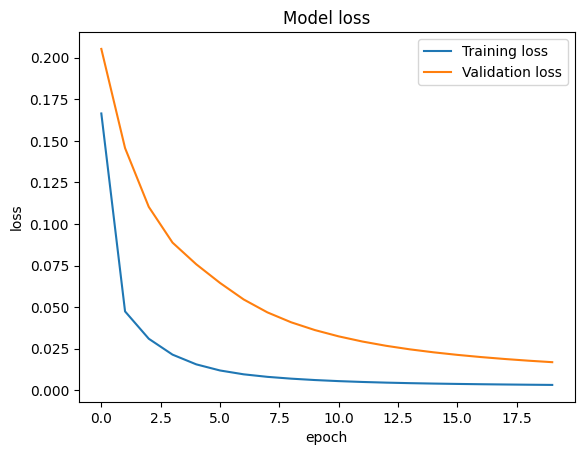

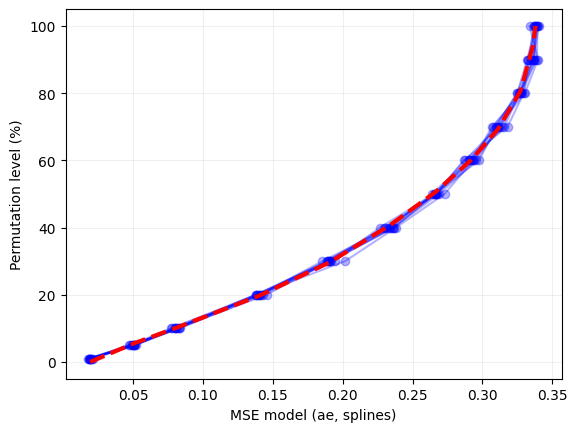

In [5]:
import random
import tensorflow as tf
tf.random.set_seed(42) 
np.random.seed(42)
random.seed(42)
print("Doing Primary Source Model -- \n" + "N = " + str(len(X_PS)) + " (" + str(np.round(len(X_PS)/(len(X_PS) + len(X_NEW))*100,2)) + " %" + " of total dataset length)")
ps_dict, ind_PS = smexp_dyn.get_PS_data(X_PS, resultspath = "../results/ds05/", dstitle = "DS 05 PS", 
                                        PSfilename = "ds05ps.pkl", mse_model_type="splines", pctge_PS=1, resultsfile="dyn-ds-05")

### New versions<br>
When a new version of the dataset is generated, it will be compared to the information from the previous version in the following way:<br>
  * $d_{P}$: computes the cosine distance between loading matrices obtained for both data sets;<br>
  * $d_{E, PCA}$: computes the MSE obtained by reconstructing the new batch using the reference PCA model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>
  * $d_{E, AE}$: computes the MSE obtained by reconstructing the new batch using the reference AE model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>


## Creation events<br>
The following experiments use an initial subset as reference and add new batches of different size.

In [6]:
print("  - Case 1: add rows of new set \n")
try:
    smexp_dyn.do_exp(X_NEW, ps_dict, resultspath = "../results/ds05", mode_der = "add_batch",
                     batchsize_pctges = [0.05, 0.1, 0.25, 0.5, 0.75, 1], dstitle="DS 05 batch addition", resultsfile="/dyn-ds-05-add")
except Exception as e: print(e)

  - Case 1: add rows of new set 

New versions, level 0.05- start
New versions, level 0.05- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.25- start
New versions, level 0.25- end
New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.75- start
New versions, level 0.75- end
New versions, level 1- start
New versions, level 1- end
DER: done


## Update events<br>

In [7]:
print("  - Case 2: transform columns ..\n")
try: 
    smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds05", mode_der = "trans_cols",
                    tr_pctges = [0.05, 0.1, 0.3, 0.5, 0.7, 0.8, 1], dstitle="DS 05 cbrt scale", batchsize_pctges=[1], kfolds=1,
                    modetr="cbrt",resultsfile="/fixed-ds-05-trcols-cbrt")
except Exception as e: print(e)

  - Case 2: transform columns ..

New versions, level 0.05- start
New versions, level 0.05- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.3- start
New versions, level 0.3- end
New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.7- start
New versions, level 0.7- end
New versions, level 0.8- start
New versions, level 0.8- end
New versions, level 1- start
New versions, level 1- end
DER: done


## Deletion of records<br>
In the following cases, the reference set contains all the records and some of them are deleted in different ways: signals are down sampled, outliers are removed, etc.

In [8]:
print("  - Case D: remove rows decimate .. \n")
try:
    smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds05", mode_der = "rem_rows_decimate", 
                            tr_pctges = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05], dstitle="DS 05 decimate", batchsize_pctges=[1], 
                            resultsfile="/fixed-ds-05-downsample")
except Exception as e: print(e)

  - Case D: remove rows decimate .. 

New versions, level 0.5- start
New versions, level 0.5- end
New versions, level 0.4- start
New versions, level 0.4- end
New versions, level 0.3- start
New versions, level 0.3- end
New versions, level 0.2- start
New versions, level 0.2- end
New versions, level 0.1- start
New versions, level 0.1- end
New versions, level 0.05- start
New versions, level 0.05- end
DER: done
